<a href="https://colab.research.google.com/github/anelglvz/Matematicas_Ciencia_Datos/blob/main/%C3%81lgebra/Low_rank_Matrix_Approximations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Título: RSVD (Randomized Singular Value Decomposition)

# Carga de datos y Limpieza

### Introducción

En este ejemplo utilizaremos los datos de la [competencia de Netflix](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data?select=combined_data_1.txt) en Kaggle. El objetivo de esta competencia era mejorar el algoritmo de recomendación 10%. Nosotros no seremos tan avariciosos. Por lo que los objetivos de esta clase son:



*   Análisis exploratorio de matriz y por qué es dispersa.
*   Implementación de Singular Value Decomposition.

Después, podríamos: 
*   Implementar de un modelo de sistema de recomendación de filtro colaborativo.
*   Generar la predicción de recomendaciones con buen resultado.

In [1]:
import math
import re

import numpy as np
import pandas as pd
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns

#from scipy.sparse import csr_matrix
#from surprise import Reader, Dataset, SVD   # Simple Python RecommendatIon System Engine
#from surprise.model_selection import cross_validate

En este caso cargar los datos nos llevará un rato por la gran cantidad de registros que tenemos. Sólo cargaremos un archivo, pero la competencia tiene un total de 3 archivos.

In [2]:
# Recuerde, pueden conseguir la dirección del archivo en su Drive y copiarla en la dirección
df = pd.read_csv('combined_data_1.txt',
                 names=['Client_Id', 'Rating', 'Date'], low_memory=True, nrows=12*(10**6))

En este dataset tenemos sólo tres columnas

In [3]:
df

,Client_Id,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26
...,...,...,...
11999995,2000580,2.0,2002-10-13
11999996,1809161,4.0,2003-06-19
11999997,1547886,2.0,2002-10-27
11999998,2905,2.0,2002-05-18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000000 entries, 0 to 11999999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Client_Id  object 
 1   Rating     float64
 2   Date       object 
dtypes: float64(1), object(2)
memory usage: 274.7+ MB


In [5]:
# Revisamos los nulos
df.isnull().sum()

Client_Id       0
Rating       2340
Date         2340
dtype: int64

En este caso los registros que tenemos con valores nulos corresponden al Id de las películas. Si observamos los registros nulos están ordenados del 1 al 2,340.

In [6]:
df[df['Rating'].isnull()].shape

(2340, 3)

In [7]:
df[df['Rating'].isnull()]

,Client_Id,Rating,Date
0,1:,NaN,NaN
548,2:,NaN,NaN
694,3:,NaN,NaN
2707,4:,NaN,NaN
2850,5:,NaN,NaN
...,...,...,...
11987100,2336:,NaN,NaN
11987192,2337:,NaN,NaN
11989727,2338:,NaN,NaN
11993647,2339:,NaN,NaN


In [8]:
movies = df['Rating'].isnull().sum()
print(f'Este es el número de películas que tenemos en este archivo: {movies}')

Este es el número de películas que tenemos en este archivo: 2340


In [9]:
reviews = df[df['Rating'].isnull()==False]['Client_Id'].count()
print(f'Este es el número de calificaciones: {reviews}')

Este es el número de calificaciones: 11997660


In [10]:
users = df['Client_Id'].nunique() - movies
print(f'Esta es la cantidad de usuarios que tenemos: {users}')

Esta es la cantidad de usuarios que tenemos: 455716


En este caso no estaremos trabajando con las fechas. Por lo tanto haremos un subconjunto de nuestro DF original.

In [11]:
df_sub = df[['Client_Id', 'Rating']]

Ahora observemos como se distribuye la frecuencia para la columna de rating.

/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_1053/2081549906.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_sub['Rating'], orient='v', palette='Blues')


<Axes: xlabel='count', ylabel='Rating'>

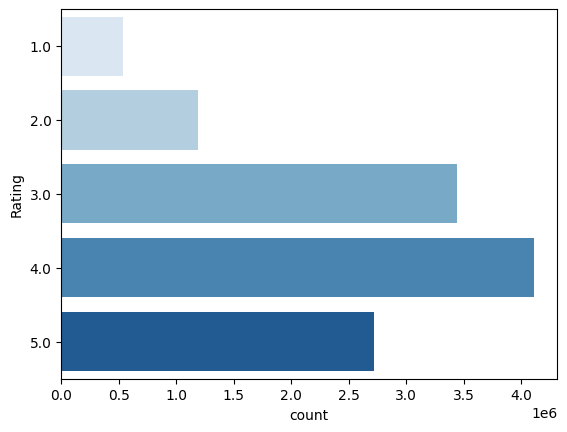

In [12]:
sns.countplot(y=df_sub['Rating'], orient='v', palette='Blues')

In [13]:
df_sub['Rating'].value_counts()/ df_sub['Rating'].count() * 100

Rating
4.0    34.239052
3.0    28.693037
5.0    22.638765
2.0     9.925744
1.0     4.503403
Name: count, dtype: float64

La mayor parte de nuestros valores se distribuyen en los ratings de 3 y 4 estrellas. La mayoría de los rating son positivos.

### Hora de la limpieza

En este caso los valores nulos que tenemos hacen referencia a **Id** de 'clientes' con rating vacíos. En realidad esta información es el **Id** de la película. Lo que debemos hacer ahora es quitar estos registros y añadir los **Id's** de película como una nueva columna.

In [14]:
# Generamos una serie con valores booleanos. Donde Verdadero será igual al lugar
# donde hay un Id de película.
pd.isnull(df_sub['Rating'][:100])

0      True
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: Rating, Length: 100, dtype: bool

In [15]:
# Colocamos la serie como un DataFrame
df_null = pd.DataFrame(pd.isnull(df_sub['Rating']))
df_null.head()

,Rating
0,True
1,False
2,False
3,False
4,False


In [17]:
# Obtenemos sólo los registros de películas junto con índice hasta donde llega
# los rating para esa película.
df_null = df_null[df_null['Rating'] == True]
df_null.head()

,index,Rating
0,0,True
548,548,True
694,694,True
2707,2707,True
2850,2850,True


In [16]:
# Colocamos el índice como columna para tener la ubicación para hasta donde repetir
# nuestros valores de Id para esa película.
df_null = df_null.reset_index()
df_null.head()

,index,Rating
0,0,True
1,1,False
2,2,False
3,3,False
4,4,False


In [19]:
movie_id_array = [] # Generamos una lista vacía donde colocaremos el Id de la película las veces que se repita.
movie_id = 1 # Inicializamos un contador

for i, j in zip(df_null['index'][1:3], df_null['index'][:-1]): # Iteramos sobre los valores de la columna 'index'
                                                               # empezando por el valor n+1 y en segundo lugar desde n hasta el penúltimo valor de la serie.
  print(i, j)
  temporary = np.full((1, i-j-1), fill_value=movie_id) # Creamos una matriz llena de valores con la forma de 1x(la diferencia del valor (n+1)-n-1).
                                                       # Esto nos da una matriz llena con el Id repetido el número de reviews para esa película.
  movie_id_array = np.append(movie_id_array, temporary) # Lo añadimos a una lista.
  movie_id += 1                                         # Aumentamos el Id para la siguiente película.




548 0
694 548


In [20]:
movie_id_array = [] # Generamos una lista vacía donde colocaremos el Id de la película las veces que se repita.
movie_id = 1 # Inicializamos un contador

for i, j in zip(df_null['index'][1:], df_null['index'][:-1]): # Iteramos sobre los valores de la columna 'index'
                                                               # empezando por el valor n+1 y en segundo lugar desde n hasta el penúltimo valor de la serie.
  temporary = np.full((1, i-j-1), fill_value=movie_id) # Creamos una matriz llena de valores con la forma de 1x(la diferencia del valor (n+1)-n-1).
                                                       # Esto nos da una matriz llena con el Id repetido el número de reviews para esa película.
  movie_id_array = np.append(movie_id_array, temporary) # Lo añadimos a una lista.
  movie_id += 1                                         # Aumentamos el Id para la siguiente película.

In [21]:
movie_id

2340

In [22]:
# Generamos los Id's para la última película que no está contemplada en nuestro loop.
last_movie = np.full((1, len(df_sub) - df_null.iloc[-1, 0] - 1), movie_id)
movie_id_array = np.append(movie_id_array, last_movie)

In [23]:
movie_id_array.shape # la cantidad de Id's corresponde con la cantidad de películas.

(11997660,)

In [24]:
movie_id_array

array([1.00e+00, 1.00e+00, 1.00e+00, ..., 2.34e+03, 2.34e+03, 2.34e+03])

Ahora para tener todo en orden es necesario que quitemos los registros nulos de nuestro df y añadamos los Id's que generamos.

In [25]:
df_clean = df_sub[pd.notnull(df_sub['Rating'])]

In [26]:
df_clean = df_clean.copy()
df_clean['Movie_Id'] = movie_id_array.astype('int16')

In [27]:
df_clean['Client_Id'] = df_clean['Client_Id'].astype('int32')

In [28]:
df_clean

,Client_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
11999995,2000580,2.0,2340
11999996,1809161,4.0,2340
11999997,1547886,2.0,2340
11999998,2905,2.0,2340


In [29]:
df_clean.tail()

,Client_Id,Rating,Movie_Id
11999995,2000580,2.0,2340
11999996,1809161,4.0,2340
11999997,1547886,2.0,2340
11999998,2905,2.0,2340
11999999,1876520,1.0,2340


In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11997660 entries, 1 to 11999999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Client_Id  int32  
 1   Rating     float64
 2   Movie_Id   int16  
dtypes: float64(1), int16(1), int32(1)
memory usage: 251.7 MB


In [31]:
print(df_clean.isnull().sum().sum())

0


### Removiendo datos con poco valor informativo

Nuestros datos se encuentran en el formato correcto. Sin embargo, existen muchos datos que no ayudan a nuestra predicción. ¿Por qué sucede esto? En esto momento no parece que tenemos valores nulos, sin embargo no todos los usuarios han calificado las 4,499 películas que tenemos. De aquí va a provenir nuestra matriz dispersa.

Pero antes de pasar a la matriz intentemos reducir la cantidad de datos que tenemos removiendo dos casos de nuestro dataset:
1. Las películas que tiene pocas calificaciones.
2. Usuarios que han calificado muy pocas películas.

In [32]:
# Agregamos a nivel película para revisar el conteo y valor promedio para cada una.
movie_agg = df_clean.groupby('Movie_Id').agg({'Rating': ['count', 'mean']})
movie_agg

Rating          
          count      mean
Movie_Id                 
1           547  3.749543
2           145  3.558621
3          2012  3.641153
4           142  2.739437
5          1140  3.919298
...         ...       ...
2336         91  3.219780
2337       2534  2.426598
2338       3919  3.046696
2339       2418  3.468983
2340       3933  2.954488

[2340 rows x 2 columns]

In [33]:
movie_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2340 entries, 1 to 2340
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Rating, count)  2340 non-null   int64  
 1   (Rating, mean)   2340 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 41.1 KB


In [34]:
movie_agg.describe()

Rating             
               count         mean
count    2340.000000  2340.000000
mean     5127.205128     3.226168
std     15580.298039     0.525592
min        43.000000     1.287879
25%       192.000000     2.894154
50%       569.500000     3.244315
75%      2517.750000     3.612134
max    193941.000000     4.581296

Observamos el comportamiento de la distribución del conteo.

<Axes: xlabel="('Rating', 'count')">

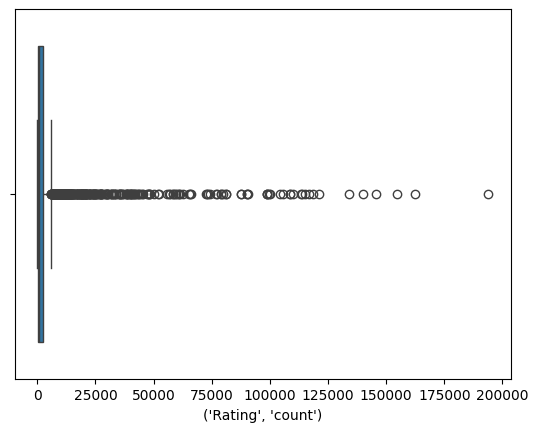

In [35]:
sns.boxplot(x=movie_agg[('Rating', 'count')])

Por el comportamiento de la distribución del conteo de nuestros ratings observamos que hay un número considerable de películas con un muy pocas calificaciones. Revisemos cuántas son.

In [36]:
# Tomamos el valor del tercer cuartil.
movies_low_rating = movie_agg[('Rating', 'count')].quantile(0.75)
print(movies_low_rating)

2517.75


In [37]:
# Seleccionamos todas las películas que están por debajo del valor del cuartil
movies_to_drop = movie_agg[movie_agg[('Rating', 'count')] < movies_low_rating].index
print(movies_to_drop.shape)

(1755,)


In [38]:
movies_to_drop

Index([   1,    2,    3,    4,    5,    6,    7,    9,   10,   11,
       ...
       2324, 2325, 2327, 2328, 2330, 2333, 2334, 2335, 2336, 2339],
      dtype='int16', name='Movie_Id', length=1755)

Ahora observemos el caso del conteo para los usuarios.

In [39]:
user_agg = df_clean.groupby('Client_Id').agg({'Rating': ['count', 'mean']})['Rating']
user_agg.head()

,count,mean
Client_Id,,
6,76,3.289474
7,93,4.107527
8,11,3.909091
10,26,3.384615
25,2,3.500000


In [40]:
user_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455716 entries, 6 to 2649429
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   count   455716 non-null  int64  
 1   mean    455716 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 8.7 MB


In [41]:
user_agg.describe()

,count,mean
count,455716.000000,455716.000000
mean,26.327055,3.680549
std,38.074139,0.627960
min,1.000000,1.000000
25%,5.000000,3.333333
50%,13.000000,3.691489
75%,33.000000,4.000000
max,2327.000000,5.000000


<Axes: xlabel='count'>

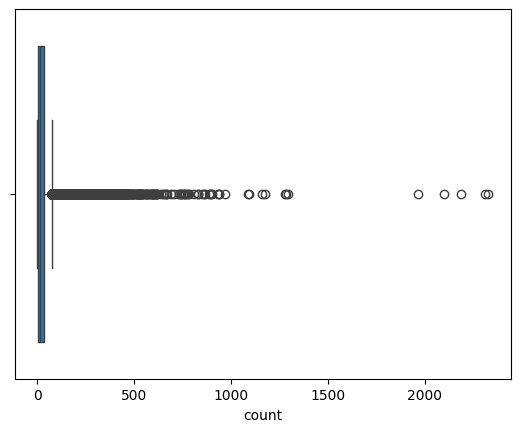

In [42]:
sns.boxplot(x=user_agg['count'])

In [43]:
user_low_rating = user_agg['count'].quantile(0.95)
print(user_low_rating)

97.0


In [44]:
users_to_drop = user_agg[user_agg['count'] < user_low_rating].index
users_to_drop.shape

(432909,)

Removamos las películas con bajo número de calificaciones tanto los usuarios con pocas películas calificadas.

In [45]:
df_trim = df_clean[~df_clean['Movie_Id'].isin(movies_to_drop)]

In [46]:
df_clean.shape, df_trim.shape

((11997660, 3), (11000284, 3))

In [47]:
df_trim = df_trim[~df_trim['Client_Id'].isin(users_to_drop)]

In [48]:
df_clean.shape, df_trim.shape

((11997660, 3), (2950702, 3))

In [49]:
df_trim.shape[0] / df_clean.shape[0]

0.2459397915926939

In [50]:
df_trim.shape

(2950702, 3)

In [51]:
df_trim

,Client_Id,Rating,Movie_Id
5119,1744889,1.0,8
5154,1205593,4.0,8
5157,1488844,4.0,8
5175,306466,4.0,8
5178,1331154,4.0,8
...,...,...,...
11999994,1946601,4.0,2340
11999996,1809161,4.0,2340
11999997,1547886,2.0,2340
11999998,2905,2.0,2340


In [52]:
len(df_trim['Client_Id'].unique())

22807

In [53]:
len(df_trim['Movie_Id'].unique())

585

# Convirtiendo a matriz dispersa o generando nuestra tabla Usuario-Item

In [54]:
pivot_user_item = df_trim.pivot(index='Movie_Id', columns='Client_Id', values='Rating').fillna(0)

In [55]:
pivot_user_item

Client_Id,769,1333,1427,1442,1500,1527,2000,2128,2213,2225,...,2648465,2648502,2648589,2648730,2648734,2648853,2648869,2648885,2649267,2649285
Movie_Id,,,,,,,,,,,,,,,,,,,,,
8,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,...,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
26,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
2332,0.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2337,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [57]:
print(pivot_user_item[pivot_user_item == 0].count().sum())

10391393


In [58]:
pivot_user_item.shape

(585, 22807)

Simplemente, al crear esta matriz dispersa la cantidad de RAM que utilizamos en el notebook sube de 2.04 Gb a 4.15 Gb aproximadamente

In [59]:
pivot_user_item.head()

Client_Id,769,1333,1427,1442,1500,1527,2000,2128,2213,2225,...,2648465,2648502,2648589,2648730,2648734,2648853,2648869,2648885,2649267,2649285
Movie_Id,,,,,,,,,,,,,,,,,,,,,
8,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,...,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
26,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# RSVD

Para información mas detallada sobre el algoritmo, consultar el artículo [Finding structure with randomness: Probabilistic algorithms for constructing
approximate matrix decompositions](https://arxiv.org/abs/0909.4061), de Halko, Martinsson y Tropp (2011)

Dicho artículo emplea métodos probabilistas para tratar de optimizar el cálculo de ciertas descomposiciones matriciales de un modo mas eficiente (computacionalmente hablando)

Con algunas matrices menos grandes (o pesadas), podríamos utilizar el algoritmo SVD de scipy, o el del módulo "Surprise" pero dado el tamaño de la matriz, estos ocuparán mucha RAM y podrían causar problemas (Por ser una matriz dispersa tan grande)

El algoritmo consta de 2 pasos importantes:

1. Calcula una base aproximada para el rango de $A$. Queremos una matriz $Q$ con $l$ columnas ortonormales ($k \leqslant l \leqslant n$) que capture la acción de A.

2. Dada dicha matriz $Q$, de tamaño mas pequeño, calcular SVD.

La parte aleatoria se utiliza en el paso 1.

La lógica detrás del paso 2 es la siguiente:

Dada una matriz ortonormal $Q$ tal que $A \approx Q Q^{*} A$:

- Hacer $B = Q^{*} A$

- Calcular SVD de $B$, es decir $B = \hat{U}\Sigma V^{*}$

- Toma $U = Q \hat{U}$

- Regresa $U$, $\Sigma$, $V^{*}$

In [60]:
def rsvd(A, rank, n_oversamples=None, n_subspace_iters=None,
         return_range=False):
    """Randomized SVD (p. 227 of Halko et al).
    :param A:                matriz (m x n) que queremos descomponer.
    :param rank:             Rango de aproximación deseado.
    :param n_oversamples:    Parametro de sobremuestreo para las muestras aleatorias Gaussianas.
    :param n_subspace_iters: Número de power iterations.
    :param return_range:     Si `True`, regresa la base aproximada del rango de A, la Q auxiliar.
    :return:                 U, S, and Vt como en el SVD truncado.
    """
    if n_oversamples is None:
        # This is the default used in the paper.
        n_samples = 2 * rank
    else:
        n_samples = rank + n_oversamples

    # Stage A.
    Q = find_range(A, n_samples, n_subspace_iters)

    # Stage B.
    B = Q.T @ A
    U_tilde, S, Vt = np.linalg.svd(B)
    U = Q @ U_tilde


    # Esto es util para calcular el error de nuestra aproximación.
    if return_range:
        return U, S, Vt, Q
    return U, S, Vt

Sea $l$ la cantidad de vectores Gaussianos aleatorios a tomar de $\Omega$:

- Se toma una matriz Gaussiana de $n\times l$, $\Omega$.

- Se genera una matriz de $m\times l$, $Y=A\Omega$

- Se genera una matriz ortonormal $Q$ (utilizando factorización QR) tal que $Y= QR$

In [61]:
def find_range(A, n_samples, n_subspace_iters=None):
    """Algoritmo 4.1: Randomized range finder (p. 240 of Halko et al).
    Dada una matriz A y un número de muestras, calcula una matriz ortonormal
    que aproxime el rango de A.

    :param A:                Matriz (m x n).
    :param n_samples:        Número de muestras aleatorias Gaussianas.
    :param n_subspace_iters: Número de iteraciones de subespacio.
    :return:                 Base ortonormal para el rango aproximado de A.
    """
    m, n = A.shape
    O = ss.norm.rvs(0, 1, (n, n_samples))
    Y = A @ O

    if n_subspace_iters:
        return subspace_iter(A, Y, n_subspace_iters)
    else:
        return ortho_basis(Y)

In [62]:
def subspace_iter(A, Y0, n_iters):
    """Algorithm 4.4: Randomized subspace iteration (p. 244 of Halko et al).
    Usa un algoritmo estable de iteración del subespacio para reducir
    los valores (número) de los valores singulares mas pequeños.

    :param A:       Matriz (m x n).
    :param Y0:      Rango inicial aprixmado de A
    :param n_iters: Número de iteracions de subespacio.

    :return:        Orthonormalized approximate range of A after power
                    iterations.
    """
    Q = ortho_basis(Y0)
    for _ in range(n_iters):
        Z = ortho_basis(A.T @ Q)
        Q = ortho_basis(A @ Z)
    return Q

In [63]:
def ortho_basis(M):
    """Calcula la base ortonormal de una matriz.

    :param M: Matriz (m x n).
    :return:  Base ortonormal de M
    """
    Q, _ = np.linalg.qr(M)  # Compute the qr factorization of a matrix.


    return Q

Nuestra matriz "pivot_user_item" tiene dimensiones $m\times n$, $U$ dimensión $m\times k$, $S$ la matriz diagonal con los eigenvalores de dimensión $k\times k$ y $V^{T}$ de dimensión $k\times n$.

In [64]:
U, S, Vt = rsvd(np.array(pivot_user_item), rank=100, n_oversamples=None, n_subspace_iters=4)

In [65]:
U.shape, S.shape, Vt.shape

((585, 200), (200,), (22807, 22807))

In [66]:
U_df = pd.DataFrame(U, index=pivot_user_item.index)
U_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Movie_Id,,,,,,,,,,,,,,,,,,,,,
8,0.012124,-0.026558,0.003268,0.009401,-0.000786,0.005864,0.027804,-0.001042,-0.005992,0.003869,...,0.026689,-0.011472,0.003541,0.022136,-0.023279,-0.054461,0.045948,-0.007796,-0.031055,0.015619
16,0.009674,0.004042,-0.027959,-0.031169,-0.013202,0.001221,0.038187,0.034753,0.002545,-0.003251,...,0.002552,-0.006303,-0.010703,-0.021058,0.001277,0.007115,-0.001842,-0.004818,-0.019025,-0.007905
17,0.006756,0.014550,-0.000869,-0.015098,0.021418,0.001982,0.022268,-0.013697,-0.025677,0.002335,...,-0.001173,0.001413,-0.007026,-0.003347,-0.002957,-0.004229,0.011865,-0.010290,-0.004715,-0.001062
18,0.028792,-0.062815,0.020533,-0.014614,-0.031495,-0.026505,0.027940,0.070660,0.007254,0.000666,...,-0.075344,0.009936,0.000746,0.085864,-0.029994,-0.039339,0.022649,-0.013869,-0.040191,-0.049286
26,0.008027,0.012271,-0.005896,-0.006735,0.025632,-0.016181,0.029959,-0.014521,-0.040319,0.000803,...,0.004881,0.015354,-0.006547,0.007418,0.006764,-0.008830,0.001431,-0.002012,-0.004056,0.008972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,0.004796,-0.013219,0.011325,0.000203,-0.008654,-0.011612,0.021823,0.007464,0.000911,0.010067,...,0.016019,-0.005294,0.005474,-0.031036,-0.010484,0.005153,-0.019169,0.012900,0.000107,0.004038
2332,0.024078,-0.059355,0.053143,-0.064695,-0.030074,-0.017460,-0.014205,-0.051748,-0.032886,-0.006268,...,-0.021655,-0.039245,-0.111172,-0.011492,-0.023181,-0.013483,0.050435,-0.068301,0.031402,-0.072976
2337,0.007953,0.015430,-0.015913,-0.013199,-0.002623,-0.007919,0.012737,0.015849,-0.038082,-0.014059,...,0.021139,0.000134,-0.005573,-0.015193,-0.003866,-0.004120,-0.001136,-0.011606,-0.009431,-0.011641


Matriz de distancias entre peliculas

In [67]:
from sklearn.metrics.pairwise import cosine_similarity

In [68]:
%%time
n,m = pivot_user_item.shape
MU = np.zeros([n,n])
for i in range(n):
  for j in range(i,n):
    MU[i,j] = MU[j,i] = cosine_similarity([U_df.iloc[i,:], U_df.iloc[j,:]])[1][0]

print(MU)

[[ 1.          0.03121001  0.07142552 ...  0.08510785  0.18463526
  -0.05000057]
 [ 0.03121001  1.          0.02529877 ...  0.22563486  0.16738458
   0.04155152]
 [ 0.07142552  0.02529877  1.         ...  0.23716005  0.12752823
  -0.16177948]
 ...
 [ 0.08510785  0.22563486  0.23716005 ...  1.          0.072267
   0.10915262]
 [ 0.18463526  0.16738458  0.12752823 ...  0.072267    1.
  -0.07868217]
 [-0.05000057  0.04155152 -0.16177948 ...  0.10915262 -0.07868217
   1.        ]]
CPU times: user 24.7 s, sys: 434 ms, total: 25.1 s
Wall time: 25.1 s


In [69]:
from numpy.linalg import matrix_rank

In [70]:
print(matrix_rank(np.array(pivot_user_item)))

585


In [71]:
print(matrix_rank(U))

200
